In [1]:
# Image classification using Convolutional Neural Network on mnist dataset

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import timeit
import math
import os

In [2]:
# Import mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Print the shape of image examples from the training, validation, and test sets
print(mnist.train.images.shape[1], mnist.train.labels.shape[1])
print(mnist.validation.images.shape[1], mnist.validation.labels.shape[1])
print(mnist.test.images.shape[1], mnist.test.labels.shape[1])

784 10
784 10
784 10


In [4]:
# print the no of examples from training, test and validation sets
print(mnist.train.num_examples, mnist.test.num_examples, mnist.validation.num_examples)

55000 10000 5000


In [5]:
# Since the class-labels are One-Hot encoded, represent the class-numbers as integers for the test set
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)

In [6]:
# One-Hot encoded labels for the first 9 images in the test set
print(mnist.test.labels[0:9, :])

# classes (output features) are needed as single numbers for comparisions and performance measures
# convert the one-hot encoded vectors to a single number by taking the index of the highest element

mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
print(mnist.test.cls[0:9])

mnist.validation.cls = np.argmax(mnist.validation.labels, axis=1)
print(mnist.validation.cls[0:9])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
[7 2 1 0 4 1 4 9 5]
[5 0 4 1 9 2 1 3 1]


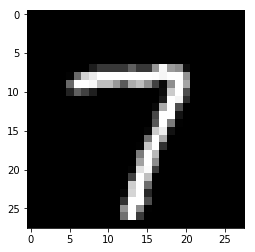

In [7]:
# Visualize any one of the images by reshaping it to a 28x28 image
plt.imshow(np.reshape(mnist.train.images[100, :], (28, 28)), cmap='gray')
plt.show()

In [8]:
# Configuration of neural network

# Convolutional Layer 1-------------------
# Convolution filters are 5x5 pixels.
# No.of filters = 16
filter_size1 = 5
num_filters1 = 32

# Convolutional Layer 2-------------------
filter_size2 = 5
num_filters2 = 32

# No. of neurons in the Fully Connected Layer
fc_size = 1024

poolsize=(2, 2)

In [9]:
# Data Dimensions

# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [10]:
# choose batch size for the training set
batch_size = 128

learning_rate = 1e-4

## Divide the Training, Validation, and Test Sets into Minibatches

In [11]:
n_train_batches = mnist.train.num_examples // batch_size
n_valid_batches = mnist.validation.num_examples // batch_size
n_test_batches = mnist.test.num_examples // batch_size

print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 429
# of Validation batches 39
# of Test batches 78


## Helper function for plotting images

In [12]:
# plot 9 images in a 3x3 grid, and print the true and predicted classes below each image
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

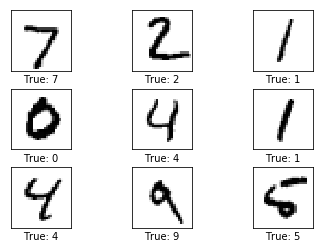

In [13]:
# Plot few images to see if data is correct
# get the first 10 images from the test-set
images = mnist.test.images[0:9]

# get the true classes for those images
cls_true = mnist.test.cls[0:9]

# plot the images and the labels using the plot helper function
plot_images(images=images, cls_true=cls_true)

## Define weights and biases

In [14]:
def new_weights(shape):
    # weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    weights = tf.Variable(tf.random_normal(shape, stddev=0.05))
    return weights

def new_biases(length):
    biases = tf.Variable(tf.constant(0.05, shape=[length]))
    return biases

## Helper function to Create a Convolutional Layer

In [15]:
# Input is a 4-D tensor: (Image number, Y-axis of each image, X-axis of each image, Channels of each image)
# Output is a 4-D tensor: (Image number, Y-axis, X-axis, channels produced by the convolutional filters)
# For output's Y-axis, if 2x2 pooling is used, then the height and width of the input images is divided by 2.

# input: previous layer
# num_input_channels: no of channels in the previous layer
# filter_size: width and height of each filter
# num_filters: no of filters
# use_pooling=True: use 2x2 max-pooling
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    
    # shape of the filter-weights for the convolution - format defined by TensorFlow api.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    print(shape)
    
    # create new weights using the shape of the filters
    weights = new_weights(shape=shape)
    print(weights)
    
    # create a new bias for each filter
    biases = new_biases(length=num_filters)
    print(biases)
    
    # create the tensorflow operation for convolution
    # set the strides to 1 in all dimensions.
    # first (image-number) and last (input-channel) stride must always be 1.
    # set padding to 'SAME' meaning the input image is padded with zeroes for the size of the output
    # to remain same.
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    print(layer)
    
    # add the biases to the results of the convolution (each filter-channel is added with a bias)
    layer += biases
    
    # use pooling to downsample the image resolution
    if use_pooling:
        # consider a 2x2 max-pooling, i.e., selecting 2x2 windows and the largest value in each window, and
        # then move 2 pixels to the next window
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    # apply ReLU to the conv layer, i.e., calculate max(x, 0) for each input pixel x and add some non-linearity
    # ReLU is normally executed before pooling, but since relu(max_pool(x)) == max_pool(relu(x)),
    # by max-pooling first, it saves 75% of the relu-operations
    layer = tf.nn.relu(layer)
    
    # To plot the weights later, return both the computed conv layer and the filter-weights
    return layer, weights

## Helper Function to Flatten the Images

In [16]:
# since a conv layer produces an output tensor with 4 dims and the fully-connected layers must later be added
# after the conv layers, we need to reduce the 4-D tensor to 2-D tensor that will be used as an input to the
# fully-connected layer
def flatten_layer(layer):
    
    # get the shape of the input layer
    # shape of the input layer: [num_images, img_height, img_width, num_channels]
    layer_shape = layer.get_shape()
    print(layer_shape)
    
    # use tensorflow function to calcluate the no of features: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    print(num_features)
    
    # reshape the layer to [num_images, num_features]
    # use -1 to avoid changing the total size of the tensor due to reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])
    print(layer_flat)
    
    # reutn the 2-D layer_flat from the 4-D layer and the number of features
    return layer_flat, num_features

## Helper function to Create a Fully Connected Layer

In [17]:
# input: 2-D tensor of shape [num_images, num_inputs]
# output: 2-D tensor of shape [num_images, num_outputs]

# input: previous layer
# num_inputs: no of inputs from the previous layer
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    
    # create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    print(weights)
    
    biases =  new_biases(length=num_outputs)
    print(biases)
    
    # calculate the layer using the matrix multiplication of the inputs and biases, and then add the bias-values
    # similar to how an output is calculated in linear regression model
    layer = tf.matmul(input, weights) + biases
    
    # use ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [18]:
# Create placeholders for input images and labels

# images placeholder
x = tf.placeholder(tf.float32, shape=[None, img_size_flat])

# placeholder for true labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])

# conv layers require input x to be encoded as a 4-D tensor, so reshape the input values to:
# [num_images, img_height, img_width, num_channels]
# num_images can be calculated automatically by using -1 for the size of the first dimension
# img_height == img_width == img_size
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# create a placeholder for class-number
y_true_cls = tf.argmax(y_true, dimension=1)

## Convolutional Layer 1

In [19]:
# Create the first Convolutional Layer
# new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True)

layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels, 
                                            filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)
print(layer_conv1)
print(weights_conv1)

[5, 5, 1, 32]
Tensor("Variable/read:0", shape=(5, 5, 1, 32), dtype=float32)
Tensor("Variable_1/read:0", shape=(32,), dtype=float32)
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("Variable/read:0", shape=(5, 5, 1, 32), dtype=float32)


## Convolutional Layer 2

In [20]:
# Create the second Convolutional Layer

layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, 
                                            filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)
print(layer_conv2)
print(weights_conv2)

[5, 5, 32, 32]
Tensor("Variable_2/read:0", shape=(5, 5, 32, 32), dtype=float32)
Tensor("Variable_3/read:0", shape=(32,), dtype=float32)
Tensor("Conv2D_1:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("Relu_1:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("Variable_2/read:0", shape=(5, 5, 32, 32), dtype=float32)


## Flatten the output from the convolutional layer 2

In [21]:
# Flatten the output from the conv layers
# Outputs of the conv layers consist of 4-D tensors. Reshape / flatten these to 2-D tensors to provide these as
# inputs to the fully-connected layer
# num_features = 7x7x36

layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat)
print(num_features)

(?, 7, 7, 32)
1568
Tensor("Reshape_1:0", shape=(?, 1568), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 1568), dtype=float32)
1568


## Fully-Connected Layer 1 

In [22]:
# Fully-Connected Layer 1
# Add the first fully-connected layer (fc1) to the network
# input is the flattened layer from the previous convolution
# no of neurons or nodes in the fc1 is fc_size
# use ReLU for non-linear relations

layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
print(layer_fc1)

Tensor("Variable_4/read:0", shape=(1568, 1024), dtype=float32)
Tensor("Variable_5/read:0", shape=(1024,), dtype=float32)
Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)


## Fully-Connected Layer 2

In [23]:
# Fully-Connected Layer 2
# output is a vector of length 10 to determine which of the classes the input image belongs to
# Since this is the final layer, ReLU is not used
# layer_fc2 gives the predicted output

layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)
print(layer_fc2)

Tensor("Variable_6/read:0", shape=(1024, 10), dtype=float32)
Tensor("Variable_7/read:0", shape=(10,), dtype=float32)
Tensor("add_3:0", shape=(?, 10), dtype=float32)


In [24]:
# Normalize the output of the fully-connected layer 2 for proper estimation of the elements

# Limit each element to between zero and one, and the 10 elements sum to one using softmax function.
y_pred = tf.nn.softmax(layer_fc2)

# Find the class number which is the index of the largest element
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Loss, Optimization, and Accuracy

In [25]:
# Minimize the cross-entropy. ( to make its value as close to zero)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# find how well the model performs on each image individually by calculating the mean of the cross_entropy for
# all image classifications
cost = tf.reduce_mean(cross_entropy)

In [26]:
# Optimize the model

# optimizer = tf.train.GradientDescentOptimizer(learning_rate)

optimizer = tf.train.AdamOptimizer(learning_rate)

global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

optimizer = optimizer.minimize(cost, global_step=global_step)

In [27]:
# Test model's accuracy for measuring performance

# correct_prediction is a vector of booleans where the predicted class equals the true class of each image
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# calculate the classification accuracy by type-casting the vector of booleans to floats (False=0, True=1), and
# then find the average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Initialize the TensorFlow Session

In [28]:
# Intialize all variables and Create TensorFlow session
init = tf.global_variables_initializer()
sess = tf.Session()

## Save the model

In [29]:
# Create a saver object to save all the variables of the neural network for storing and retrieving it later.

saver = tf.train.Saver()

# create a directory for saving the checkpoints that get written at regular intervals during optimization
save_dir = "checkpoints_mnist_cnn/"
# create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# path for the checkpoint file
save_path = os.path.join(save_dir, "mnist_cnn.ckpt")
if os.path.exists(save_path):
    print("Checkpoint created.")
else:
    print("No checkpoint exists as of now!!!!")

No checkpoint exists as of now!!!!


## Restore or Initialize Variables for TensorFlow Graph

In [30]:
# restore the latest checkpoint if available from the checkpoint directory
try:
    print("Trying to restore the latest checkpoint....")
    
    # search for the latest checkpoint
    last_ckpt_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    # load the data from the checkpoint file
    saver.restore(sess, save_path=last_ckpt_path)
    
    print("Checkpoint restored from: ", last_ckpt_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead...")
    sess.run(init)

Trying to restore the latest checkpoint....
Failed to restore checkpoint. Initializing variables instead...


## Helper Function to Perform Training

In [31]:
def optimize(n_epochs):
    
    finished = False
    curr_epoch = 0
    
    # start the timer
    start_time = timeit.default_timer()
    
    while (curr_epoch < n_epochs) and (not finished):
        
        # increment the no of iterations by 1
        curr_epoch += 1
        
        # get a batch of training examples
        # x_batch for images and y_batch for labels of these images
        x_batch, y_true_batch = mnist.train.next_batch(batch_size)
        
        # create a dictionary of above training batches that needs to be fed to the placeholder variables
        # y_true_cls is not set as it is not used during training
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        for minibatch_i in range(n_train_batches):
            
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            if ((iter + 1) % n_train_batches == 0):
        
                # run the optimizer using the batch of training data
                # retrieve the global step counter
                global_step_, optimizer_, cost_ = sess.run([global_step, optimizer, cost], 
                                                           feed_dict=feed_dict_train)
            
                # calculate the accuracy of the training set.
                train_accuracy = sess.run(accuracy, feed_dict=feed_dict_train)

                # calculate the accuracy of the validation set.
                valid_accuracy, _ = validation_accuracy()
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)

                # print the accuracy message
                output = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
                print(output.format(train_accuracy, valid_accuracy))
            
#                 print("Training Cost: ", cost_)
                
                
                # save all variables to a checkpoint and append the total_interations counter to the filename
                saver.save(sess, save_path=save_path, global_step=global_step_)
                print("Checkpoint Saved...")
                
                print("=====================================================================")
                print("=====================================================================")
        
    # end the timer
    end_time = timeit.default_timer()
        
    # total time taken to perform the iterations
    time_diff = end_time - start_time
    
    print(("Training Accuracy %f %%, Validation Accuracy %f %%") % (train_accuracy, valid_accuracy))

    print("The code ran for %.1fs" % (time_diff))
    
    print("The code ran for %.2fm" % (time_diff / 60.))

## Helper function to plot example errors

In [32]:
# Plot examples of images from the test-set that have been misclassified

def plot_examples_errors(cls_pred, correct):
    
    # negate the boolean array
    incorrect = (correct == False)
    
    # get the images from the test-set that have been incorrectly classified
    images = mnist.test.images[incorrect]
    
    # get the predicted class for the above incorrectly classified images
    cls_pred = cls_pred[incorrect]
    
    # get the true class for the above images
    cls_true = mnist.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

## Helper function to plot confusion matrix using scikit-learn

In [33]:
def plot_confusion_matrix(cls_pred):
    
    # get the true classifications for the test-set
    cls_true = mnist.test.cls
    
    # create a dictionary of test examples
    feed_dict_test = {x: mnist.test.images, y_true: mnist.test.labels, y_true_cls: cls_true}
    
    # cls_pred is an array of the predicted class number for all images in the test-set
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix as text
    print(cm)
    
    # plot the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.matshow(cm)
    
    # adjust the plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Helper Functions to Predict the Classifications

In [34]:
def predict_cls(images, labels, cls_true):
    
    # no of images
    num_images = len(images)
    
    # allocate an array for the predicted classes which will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    # calculate the predicted classes for the batches by iterating through all the batches
    
    # starting index (i) for the next batch
    i = 0
    
    while i < num_images:
        # ending index (j) for the next batch
        j = min(i + batch_size, num_images)
        
        # create a feed-dict with the images and labels between index i and j
        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        
        # calculate the predicted class using TensorFlow
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        
        # set the start-index of the next batch to the end-index of the current batch
        i = j
        
    # create a boolean array to check whether each image is correctly classified
    correct = (cls_true == cls_pred)
    label_names = mnist.test.labels
    return correct, cls_pred

In [35]:
# calculate predicted class for the test-set and validation-set

def predict_cls_test():
    return predict_cls(images = mnist.test.images, labels = mnist.test.labels, cls_true = mnist.test.cls)

def predict_cls_validation():
    return predict_cls(images = mnist.validation.images, labels = mnist.validation.labels, 
                       cls_true = mnist.validation.cls)

## Helper Functions to calculate the Classification Accuracy

In [36]:
# Define a helper function to calculates the classification accuracy given a boolean array to check if each image 
# was correctly classified.
# e.g: cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4

def cls_accuracy(correct):
    # calculate the no of correctly classified images.
    # 0 = False, 1 = True
    correct_sum = correct.sum()
    
    # classification accuracy = no of correctly classified images / total no of images in the given dataset
    cls_accuracy = float(correct_sum) / len(correct)
    
    return cls_accuracy, correct_sum

In [37]:
# Define a function to find the classification accuracy on the validation set
def validation_accuracy():
    correct, _ = predict_cls_validation()
    
    return cls_accuracy(correct)

In [38]:
# Define a function to print the classification accuracy on the test-set

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    # for all the images in the test-set, calculate the predicted class and check if they are correct
    correct, cls_pred = predict_cls_test()
    
    # classification accuracy and the no of correct classifications
    test_accuracy, num_correct = cls_accuracy(correct)
    
    # no of images being classified
    num_images = len(correct)
    
    
    # print the accuracy
    msg = "Test-Set Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(test_accuracy, num_correct, num_images))
    
    # plot some examples of misclassifications
    if show_example_errors:
        print("Example errors:")
        plot_examples_errors(cls_pred=cls_pred, correct=correct)
        
    # plot the confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper Function to Plot the Weights

In [39]:
def plot_conv_weights(weights, input_channel=0):
    
    # get the values of the weight-variables from TensorFlow.
    w = sess.run(weights)
    # print(w)
    
    # get the lowest and the highest values for the weights in order to correct the color intensity
    # across the images to compare them with each other
    w_min = np.min(w)
    w_max = np.max(w)
    
    # no of filters used in the conv layer
    num_filters = w.shape[3]
    print("No of filters:", num_filters)
    
    # no of grids to plot. (rounded up, square-root of the no of filters)
    num_grids = math.ceil(math.sqrt(num_filters))
    print(num_grids)
    
    # create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        
        # only plot the valid filter-weights
        if i < num_filters:
            # get the weights for the i'th filter of the input channel
            # refer new_conv_layer() for the shape of this 4-D tensor
            # shape = [filter_size, filter_size, num_input_channels, num_filters]
            img = w[:, :, input_channel, i]
            
            # plot the image
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # display the plot
    plt.show()

## Perform Training

## Performance of the model before any optimization

In [40]:
print("Accuracy of the model before training")
print_test_accuracy()

Accuracy of the model before training
Test-Set Accuracy: 9.9% (991 / 10000)


## Performance of the Model after 1500 epochs

In [41]:
print("Starting Training Operation with a batch size of", batch_size)
optimize(n_epochs=1500)

Starting Training Operation with a batch size of 128
Epoch 1, Minibatch 429/429 
Training Accuracy:  18.0%, Validation Accuracy:  11.7%
Checkpoint Saved...
Epoch 2, Minibatch 429/429 
Training Accuracy:  17.2%, Validation Accuracy:  18.8%
Checkpoint Saved...
Epoch 3, Minibatch 429/429 
Training Accuracy:  33.6%, Validation Accuracy:  32.5%
Checkpoint Saved...
Epoch 4, Minibatch 429/429 
Training Accuracy:  34.4%, Validation Accuracy:  32.8%
Checkpoint Saved...
Epoch 5, Minibatch 429/429 
Training Accuracy:  27.3%, Validation Accuracy:  27.7%
Checkpoint Saved...
Epoch 6, Minibatch 429/429 
Training Accuracy:  29.7%, Validation Accuracy:  26.6%
Checkpoint Saved...
Epoch 7, Minibatch 429/429 
Training Accuracy:  27.3%, Validation Accuracy:  28.6%
Checkpoint Saved...
Epoch 8, Minibatch 429/429 
Training Accuracy:  33.6%, Validation Accuracy:  33.9%
Checkpoint Saved...
Epoch 9, Minibatch 429/429 
Training Accuracy:  36.7%, Validation Accuracy:  41.7%
Checkpoint Saved...
Epoch 10, Minibatch 

Epoch 35, Minibatch 429/429 
Training Accuracy:  77.3%, Validation Accuracy:  75.0%
Checkpoint Saved...
Epoch 36, Minibatch 429/429 
Training Accuracy:  79.7%, Validation Accuracy:  75.1%
Checkpoint Saved...
Epoch 37, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  75.8%
Checkpoint Saved...
Epoch 38, Minibatch 429/429 
Training Accuracy:  76.6%, Validation Accuracy:  77.7%
Checkpoint Saved...
Epoch 39, Minibatch 429/429 
Training Accuracy:  85.2%, Validation Accuracy:  79.9%
Checkpoint Saved...
Epoch 40, Minibatch 429/429 
Training Accuracy:  78.1%, Validation Accuracy:  81.3%
Checkpoint Saved...
Epoch 41, Minibatch 429/429 
Training Accuracy:  82.0%, Validation Accuracy:  80.5%
Checkpoint Saved...
Epoch 42, Minibatch 429/429 
Training Accuracy:  81.2%, Validation Accuracy:  79.8%
Checkpoint Saved...
Epoch 43, Minibatch 429/429 
Training Accuracy:  78.1%, Validation Accuracy:  79.6%
Checkpoint Saved...
Epoch 44, Minibatch 429/429 
Training Accuracy:  82.8%, Validati

Epoch 69, Minibatch 429/429 
Training Accuracy:  78.9%, Validation Accuracy:  83.8%
Checkpoint Saved...
Epoch 70, Minibatch 429/429 
Training Accuracy:  82.0%, Validation Accuracy:  84.2%
Checkpoint Saved...
Epoch 71, Minibatch 429/429 
Training Accuracy:  79.7%, Validation Accuracy:  84.4%
Checkpoint Saved...
Epoch 72, Minibatch 429/429 
Training Accuracy:  77.3%, Validation Accuracy:  84.7%
Checkpoint Saved...
Epoch 73, Minibatch 429/429 
Training Accuracy:  78.1%, Validation Accuracy:  84.9%
Checkpoint Saved...
Epoch 74, Minibatch 429/429 
Training Accuracy:  82.8%, Validation Accuracy:  85.0%
Checkpoint Saved...
Epoch 75, Minibatch 429/429 
Training Accuracy:  80.5%, Validation Accuracy:  84.8%
Checkpoint Saved...
Epoch 76, Minibatch 429/429 
Training Accuracy:  71.9%, Validation Accuracy:  84.9%
Checkpoint Saved...
Epoch 77, Minibatch 429/429 
Training Accuracy:  77.3%, Validation Accuracy:  85.3%
Checkpoint Saved...
Epoch 78, Minibatch 429/429 
Training Accuracy:  86.7%, Validati

Epoch 103, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  87.3%
Checkpoint Saved...
Epoch 104, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  87.3%
Checkpoint Saved...
Epoch 105, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  87.2%
Checkpoint Saved...
Epoch 106, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  87.0%
Checkpoint Saved...
Epoch 107, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  87.4%
Checkpoint Saved...
Epoch 108, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  88.7%
Checkpoint Saved...
Epoch 109, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  89.0%
Checkpoint Saved...
Epoch 110, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  88.5%
Checkpoint Saved...
Epoch 111, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  87.8%
Checkpoint Saved...
Epoch 112, Minibatch 429/429 
Training Accuracy:  89.1%

Epoch 137, Minibatch 429/429 
Training Accuracy:  85.2%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 138, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 139, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 140, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 141, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  88.1%
Checkpoint Saved...
Epoch 142, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  87.5%
Checkpoint Saved...
Epoch 143, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  87.4%
Checkpoint Saved...
Epoch 144, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  88.0%
Checkpoint Saved...
Epoch 145, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 146, Minibatch 429/429 
Training Accuracy:  89.8%

Epoch 171, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 172, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 173, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 174, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 175, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 176, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 177, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 178, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  90.7%
Checkpoint Saved...
Epoch 179, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 180, Minibatch 429/429 
Training Accuracy:  93.0%

Epoch 205, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 206, Minibatch 429/429 
Training Accuracy:  82.8%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 207, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 208, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 209, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 210, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 211, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 212, Minibatch 429/429 
Training Accuracy:  86.7%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 213, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 214, Minibatch 429/429 
Training Accuracy:  85.9%

Epoch 239, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 240, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 241, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 242, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  92.7%
Checkpoint Saved...
Epoch 243, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 244, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 245, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 246, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 247, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 248, Minibatch 429/429 
Training Accuracy:  96.9%

Epoch 273, Minibatch 429/429 
Training Accuracy:  86.7%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 274, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 275, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 276, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 277, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  93.2%
Checkpoint Saved...
Epoch 278, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 279, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 280, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 281, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 282, Minibatch 429/429 
Training Accuracy:  90.6%

Epoch 307, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  93.5%
Checkpoint Saved...
Epoch 308, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  93.6%
Checkpoint Saved...
Epoch 309, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  93.5%
Checkpoint Saved...
Epoch 310, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  93.5%
Checkpoint Saved...
Epoch 311, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  93.5%
Checkpoint Saved...
Epoch 312, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  93.4%
Checkpoint Saved...
Epoch 313, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 314, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 315, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 316, Minibatch 429/429 
Training Accuracy:  93.8%

Epoch 341, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  93.7%
Checkpoint Saved...
Epoch 342, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  93.7%
Checkpoint Saved...
Epoch 343, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  93.4%
Checkpoint Saved...
Epoch 344, Minibatch 429/429 
Training Accuracy:  85.2%, Validation Accuracy:  93.2%
Checkpoint Saved...
Epoch 345, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 346, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 347, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 348, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  93.4%
Checkpoint Saved...
Epoch 349, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  93.4%
Checkpoint Saved...
Epoch 350, Minibatch 429/429 
Training Accuracy:  95.3%

Epoch 375, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  93.7%
Checkpoint Saved...
Epoch 376, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  93.6%
Checkpoint Saved...
Epoch 377, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  93.6%
Checkpoint Saved...
Epoch 378, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  93.8%
Checkpoint Saved...
Epoch 379, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  94.1%
Checkpoint Saved...
Epoch 380, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  94.2%
Checkpoint Saved...
Epoch 381, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 382, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  94.6%
Checkpoint Saved...
Epoch 383, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 384, Minibatch 429/429 
Training Accuracy:  92.2%

Epoch 409, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 410, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  94.6%
Checkpoint Saved...
Epoch 411, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 412, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 413, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  94.3%
Checkpoint Saved...
Epoch 414, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 415, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 416, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 417, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 418, Minibatch 429/429 
Training Accuracy:  96.9%

Epoch 443, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  94.6%
Checkpoint Saved...
Epoch 444, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 445, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  94.6%
Checkpoint Saved...
Epoch 446, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  94.8%
Checkpoint Saved...
Epoch 447, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  94.8%
Checkpoint Saved...
Epoch 448, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  94.6%
Checkpoint Saved...
Epoch 449, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  94.7%
Checkpoint Saved...
Epoch 450, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  94.7%
Checkpoint Saved...
Epoch 451, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  94.7%
Checkpoint Saved...
Epoch 452, Minibatch 429/429 
Training Accuracy:  96.1%

Epoch 477, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 478, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.1%
Checkpoint Saved...
Epoch 479, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.1%
Checkpoint Saved...
Epoch 480, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  95.2%
Checkpoint Saved...
Epoch 481, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 482, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  95.4%
Checkpoint Saved...
Epoch 483, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 484, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 485, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 486, Minibatch 429/429 
Training Accuracy:  92.2%

Epoch 511, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 512, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 513, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.2%
Checkpoint Saved...
Epoch 514, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.1%
Checkpoint Saved...
Epoch 515, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  95.2%
Checkpoint Saved...
Epoch 516, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.2%
Checkpoint Saved...
Epoch 517, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  95.2%
Checkpoint Saved...
Epoch 518, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 519, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 520, Minibatch 429/429 
Training Accuracy:  94.5%

Epoch 545, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.5%
Checkpoint Saved...
Epoch 546, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 547, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 548, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 549, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 550, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  95.5%
Checkpoint Saved...
Epoch 551, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.4%
Checkpoint Saved...
Epoch 552, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.3%
Checkpoint Saved...
Epoch 553, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.1%
Checkpoint Saved...
Epoch 554, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 579, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 580, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 581, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 582, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 583, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 584, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 585, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 586, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 587, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 588, Minibatch 429/429 
Training Accuracy:  96.1%

Epoch 613, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 614, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.8%
Checkpoint Saved...
Epoch 615, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 616, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.6%
Checkpoint Saved...
Epoch 617, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.5%
Checkpoint Saved...
Epoch 618, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  95.5%
Checkpoint Saved...
Epoch 619, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  95.7%
Checkpoint Saved...
Epoch 620, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 621, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.2%
Checkpoint Saved...
Epoch 622, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 647, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  96.1%
Checkpoint Saved...
Epoch 648, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.3%
Checkpoint Saved...
Epoch 649, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.2%
Checkpoint Saved...
Epoch 650, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.2%
Checkpoint Saved...
Epoch 651, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  96.2%
Checkpoint Saved...
Epoch 652, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.2%
Checkpoint Saved...
Epoch 653, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.1%
Checkpoint Saved...
Epoch 654, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 655, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  95.9%
Checkpoint Saved...
Epoch 656, Minibatch 429/429 
Training Accuracy:  96.9%

Epoch 681, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.5%
Checkpoint Saved...
Epoch 682, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.4%
Checkpoint Saved...
Epoch 683, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  96.4%
Checkpoint Saved...
Epoch 684, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  96.5%
Checkpoint Saved...
Epoch 685, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  96.5%
Checkpoint Saved...
Epoch 686, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.4%
Checkpoint Saved...
Epoch 687, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  96.4%
Checkpoint Saved...
Epoch 688, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.4%
Checkpoint Saved...
Epoch 689, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  96.3%
Checkpoint Saved...
Epoch 690, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 715, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 716, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 717, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 718, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 719, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 720, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 721, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 722, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 723, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.5%
Checkpoint Saved...
Epoch 724, Minibatch 429/429 
Training Accuracy:  96.1%

Epoch 749, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.8%
Checkpoint Saved...
Epoch 750, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 751, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 752, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 753, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 754, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 755, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 756, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.8%
Checkpoint Saved...
Epoch 757, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 758, Minibatch 429/429 
Training Accuracy:  96.9%

Epoch 783, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 784, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 785, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 786, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.8%
Checkpoint Saved...
Epoch 787, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.7%
Checkpoint Saved...
Epoch 788, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.8%
Checkpoint Saved...
Epoch 789, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 790, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 791, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.6%
Checkpoint Saved...
Epoch 792, Minibatch 429/429 
Training Accuracy:  96.9%

Epoch 817, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 818, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 819, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 820, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 821, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 822, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 823, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 824, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 825, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 826, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 851, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 852, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 853, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 854, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 855, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 856, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 857, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.2%
Checkpoint Saved...
Epoch 858, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 859, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 860, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 885, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.2%
Checkpoint Saved...
Epoch 886, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 887, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 888, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 889, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 890, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 891, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 892, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 893, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 894, Minibatch 429/429 
Training Accuracy:  98.4%

Epoch 919, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 920, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  96.9%
Checkpoint Saved...
Epoch 921, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 922, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 923, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 924, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 925, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.2%
Checkpoint Saved...
Epoch 926, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 927, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.0%
Checkpoint Saved...
Epoch 928, Minibatch 429/429 
Training Accuracy:  96.1%

Epoch 953, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 954, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 955, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 956, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 957, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 958, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 959, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 960, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 961, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 962, Minibatch 429/429 
Training Accuracy:  96.1%

Epoch 987, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 988, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 989, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 990, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 991, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 992, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 993, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 994, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 995, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 996, Minibatch 429/429 
Training Accuracy:  97.7%

Epoch 1021, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 1022, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 1023, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1024, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1025, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1026, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1027, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 1028, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 1029, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1030, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1055, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1056, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1057, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1058, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1059, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1060, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1061, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1062, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1063, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1064, Minibatch 429/

Epoch 1088, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.1%
Checkpoint Saved...
Epoch 1089, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 1090, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.4%
Checkpoint Saved...
Epoch 1091, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 1092, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1093, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1094, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1095, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 1096, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.3%
Checkpoint Saved...
Epoch 1097, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1122, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1123, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1124, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1125, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1126, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1127, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1128, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1129, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1130, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1131, Minibatch 429/

Epoch 1155, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1156, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1157, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1158, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1159, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1160, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1161, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1162, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1163, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1164, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1189, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1190, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1191, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1192, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1193, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1194, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1195, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1196, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1197, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1198, Minibatch 429/

Epoch 1222, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1223, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1224, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.5%
Checkpoint Saved...
Epoch 1225, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1226, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1227, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1228, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1229, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1230, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1231, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1256, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1257, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1258, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1259, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1260, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1261, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1262, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1263, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1264, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1265, Minibatch 429/

Epoch 1289, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1290, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1291, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1292, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1293, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1294, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1295, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1296, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1297, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1298, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1323, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1324, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1325, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1326, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1327, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1328, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1329, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1330, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1331, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1332, Minibatch 429/

Epoch 1356, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1357, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1358, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1359, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1360, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1361, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1362, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1363, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1364, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1365, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1390, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1391, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1392, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.2%
Checkpoint Saved...
Epoch 1393, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.3%
Checkpoint Saved...
Epoch 1394, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.2%
Checkpoint Saved...
Epoch 1395, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1396, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1397, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1398, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.6%
Checkpoint Saved...
Epoch 1399, Minibatch 429/

Epoch 1423, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1424, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1425, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1426, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1427, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1428, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  97.8%
Checkpoint Saved...
Epoch 1429, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1430, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1431, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1432, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 1457, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1458, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  97.7%
Checkpoint Saved...
Epoch 1459, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1460, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1461, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1462, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1463, Minibatch 429/429 
Training Accuracy:  98.4%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1464, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1465, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1466, Minibatch 429/

Epoch 1490, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  97.9%
Checkpoint Saved...
Epoch 1491, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  98.0%
Checkpoint Saved...
Epoch 1492, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.1%
Checkpoint Saved...
Epoch 1493, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  98.2%
Checkpoint Saved...
Epoch 1494, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.3%
Checkpoint Saved...
Epoch 1495, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.4%
Checkpoint Saved...
Epoch 1496, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  98.3%
Checkpoint Saved...
Epoch 1497, Minibatch 429/429 
Training Accuracy: 100.0%, Validation Accuracy:  98.3%
Checkpoint Saved...
Epoch 1498, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  98.2%
Checkpoint Saved...
Epoch 1499, Minibatch 429/429 
Training Accura

Accuracy of the model after training for 1500 epochs
Test-Set Accuracy: 97.7% (9769 / 10000)
Example errors:


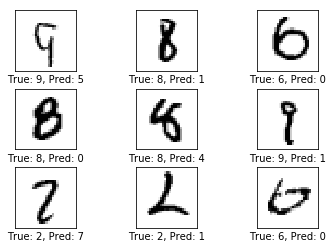

In [42]:
print("Accuracy of the model after training for 1500 epochs")
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

Test-Set Accuracy: 97.7% (9769 / 10000)
Confusion Matrix:
[[ 973    0    1    1    0    3    1    1    0    0]
 [   0 1130    3    0    0    0    1    0    1    0]
 [   5    9 1008    0    2    0    0    7    1    0]
 [   1    0    1  994    0    7    0    4    2    1]
 [   1    1    3    0  968    0    2    1    2    4]
 [   2    0    1    1    0  884    3    1    0    0]
 [  10    5    1    0    3    8  931    0    0    0]
 [   1    9   10    2    0    0    0 1003    0    3]
 [  11    6    4    9    6   14    2    6  910    6]
 [   8    7    1    6    8    5    0    6    0  968]]


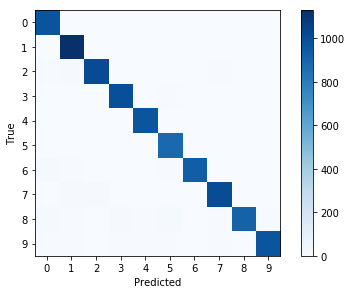

In [43]:
print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

## Helper Function To Plot the Output of a Convolutional Layer

In [44]:
def plot_conv_layer(layer, image):
    
    # output of the convolutional layer is a 4-D tensor
    # create a feed-dict containing just one image, no need to feed y_true
    feed_dict = {x: [image]}
    
    # Calculate and retrieve the output values of the layer when inputting the image
    values = sess.run(layer, feed_dict=feed_dict)
    # print(values)
    print(values.shape)
    
    # no of filters used in the conv layer
    num_filters = values.shape[3]
    print(num_filters)
    
    # no of grids to plot. (rounded up, square-root of the no of filters)
    num_grids = math.ceil(math.sqrt(num_filters))
    print(num_grids)
    
    # create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        
        # only plot the valid filter-weights
        if i < num_filters:
            # get the weights for the i'th filter of the input channel
            # refer new_conv_layer() for the shape of this 4-D tensor
            # shape = [filter_size, filter_size, num_input_channels, num_filters]
            img = values[0, :, :, i]
            
            # plot the image
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # display the plot
    plt.show()

In [45]:
# Helper-function for plotting an image

def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    plt.show()

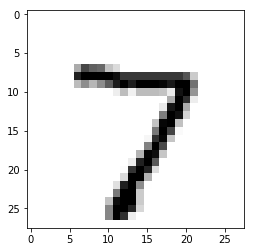

In [46]:
# Plot an image from the test-set as an example.
image1 = mnist.test.images[0]
plot_image(image1)

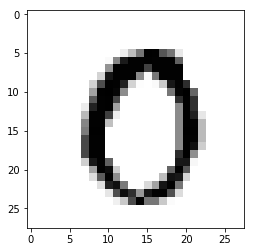

In [47]:
# Plot another example from the test-set
image2 = mnist.test.images[13]
plot_image(image2)

## Convolutional Layer 1 - Plotting

No of filters: 32
6


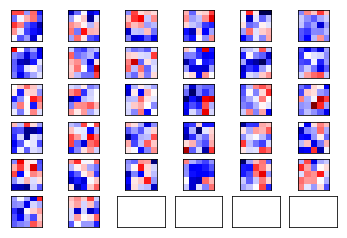

In [48]:
# Plot the filter-weights for the first convolutional layer 1
# red - positive weights, blue - negative weights

plot_conv_weights(weights=weights_conv1)

(1, 14, 14, 32)
32
6


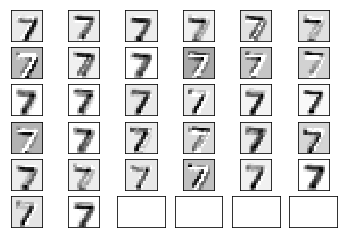

In [49]:
# Apply each of the convolutional filters to the first input image to produce output images that can be used as
# input to the second convolutional layer.
# images are down-sampled to 14x14 pixels (1/2 of original input image's resolution)

plot_conv_layer(layer=layer_conv1, image=image1)

(1, 14, 14, 32)
32
6


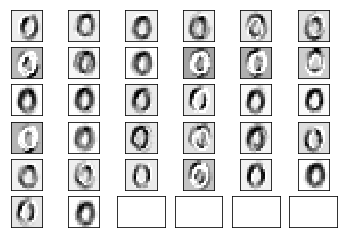

In [50]:
# apply convolutional filters to the second example image
plot_conv_layer(layer=layer_conv1, image=image2)

## Convolutional Layer 2 - Plotting

No of filters: 32
6


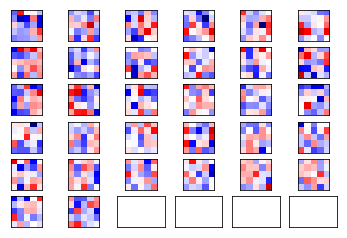

In [51]:
# Plot the filter-weights for the second convolutional layer 2
# 16 outputs from the first conv-layer = 16 input channels to the second conv-layer
# the 2nd conv-layer has a set of filter-weights for each of its input channels.
# since there are 16 channels, a total of 16 plots of filter-weights can be made.
# let's plot the filter-weight for the first channel

plot_conv_weights(weights=weights_conv2, input_channel=0)

No of filters: 32
6


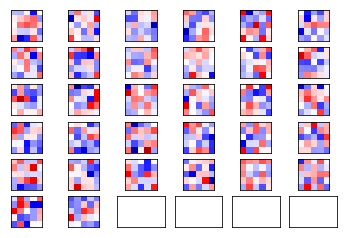

In [52]:
# plot filter-weight for the second channel
plot_conv_weights(weights=weights_conv2, input_channel=1)

(1, 7, 7, 32)
32
6


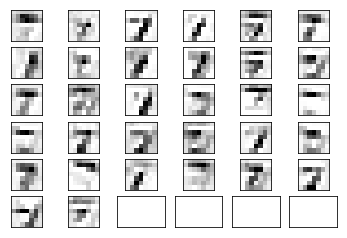

In [53]:
# Apply the convolutional filters to the images that were output from the first conv-layer
# Images are again down-sampled to 7x7 pixels

plot_conv_layer(layer=layer_conv2, image=image1)

(1, 7, 7, 32)
32
6


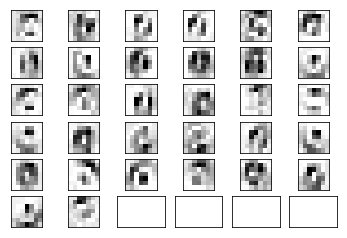

In [54]:
# Apply convolutional filters to the second image
plot_conv_layer(layer=layer_conv2, image=image2)

In [55]:
feed_dict = {x: [image1]}
values_fc1 = sess.run(layer_fc1, feed_dict=feed_dict)
print(values_fc1)
print()
print(values_fc1.shape)

[[ 0.          0.          0.05226544 ...,  0.          0.37439084
   1.18421459]]

(1, 1024)


In [56]:
values_fc2 = sess.run(layer_fc2, feed_dict=feed_dict)
print(values_fc2)
print()
print(values_fc2.shape)

[[ -1.58004892  -2.92928028   2.02348852   2.59498429  -5.48897552
   -1.93909919 -12.49024391  12.26463223  -2.93307137   0.81028908]]

(1, 10)


In [57]:
# sess.close()